In [ ]:

import random
import numpy as np
import tensorflow as tf

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

2025-05-09 18:53:37.796932: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-09 18:53:37.806252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746834817.817869  303611 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746834817.821786  303611 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 18:53:37.835762: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:

CONFIG = {
    "data_path": "data/emnist_balanced.npz",
    "mapping_file": "emnist-balanced-mapping.txt",
    "model_checkpoint": "savedModels/CNN-Model.keras",
    "batch_size": 64,
    "epochs": 20,
    "input_shape": (28, 28, 1),
    "num_classes": 47,
    "test_path": "path/to/your/image.png",  # Update this path for inference
}
NUM_CLASSES = 47


In [3]:
import numpy as np
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from tensorflow.keras import layers, models, optimizers, callbacks

# Reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
# Ensures determinism on GPU (helps debugging)
tf.config.experimental.enable_op_determinism()


In [ ]:

data = np.load('data/emnist_balanced.npz')
x = data['x']
y = data['y']


x = np.transpose(x, (0, 2, 1))
x = np.flip(x, axis=2)


x = x.astype('float32') / 255.0
x = x[..., np.newaxis]

print(f"Data shapes before split: {x.shape}, {y.shape}")


Data shapes before split: (112800, 28, 28, 1), (112800,)


In [ ]:

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=seed)
train_idx, test_idx = next(sss.split(x, y))
x_train_full, x_test = x[train_idx], x[test_idx]
y_train_full, y_test = y[train_idx], y[test_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=seed)
train_idx, val_idx = next(sss2.split(x_train_full, y_train_full))
x_train, x_val = x_train_full[train_idx], x_train_full[val_idx]
y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")


Train: (91368, 28, 28, 1), Val: (10152, 28, 28, 1), Test: (11280, 28, 28, 1)


In [ ]:

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=seed)
train_idx, test_idx = next(sss.split(x, y))
x_train_full, x_test = x[train_idx], x[test_idx]
y_train_full, y_test = y[train_idx], y[test_idx]

sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=seed)
train_idx, val_idx = next(sss_val.split(x_train_full, y_train_full))
x_train, x_val = x_train_full[train_idx], x_train_full[val_idx]
y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")


Train: (91368, 28, 28, 1), Val: (10152, 28, 28, 1), Test: (11280, 28, 28, 1)


In [ ]:


import tensorflow as tf
from tensorflow.keras import models, optimizers
from tensorflow.keras import layers


checkpoint_path = 'RNN-Model-v2.keras'
cb = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

import os
os.makedirs('savedModels', exist_ok=True)


model = models.Sequential([
    layers.Input(shape=CONFIG["input_shape"]),
    # Treat each 28‑pixel row as a timestep of 28 features
    layers.Reshape((CONFIG["input_shape"][0], CONFIG["input_shape"][1])),
    layers.LSTM(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(CONFIG["num_classes"], activation='softmax'),
], name='model')

model.compile(
    optimizer=optimizers.Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)
    ]
)

history_rnn = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=CONFIG["epochs"],
    batch_size=CONFIG["batch_size"],
    callbacks=cb,
    verbose=2
)


I0000 00:00:1746834820.566472  303611 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6181 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/20


2025-05-09 18:53:41.543947: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
I0000 00:00:1746834822.527048  303716 cuda_dnn.cc:529] Loaded cuDNN version 90800


1428/1428 - 6s - 4ms/step - accuracy: 0.1974 - loss: 2.9246 - sparse_top_k_categorical_accuracy: 0.4029 - val_accuracy: 0.0222 - val_loss: 10.0823 - val_sparse_top_k_categorical_accuracy: 0.1727 - learning_rate: 3.0000e-04
Epoch 2/20
1428/1428 - 4s - 3ms/step - accuracy: 0.3792 - loss: 2.1374 - sparse_top_k_categorical_accuracy: 0.6548 - val_accuracy: 0.0869 - val_loss: 8.5112 - val_sparse_top_k_categorical_accuracy: 0.1850 - learning_rate: 3.0000e-04
Epoch 3/20
1428/1428 - 4s - 3ms/step - accuracy: 0.4682 - loss: 1.8251 - sparse_top_k_categorical_accuracy: 0.7438 - val_accuracy: 0.1984 - val_loss: 4.3452 - val_sparse_top_k_categorical_accuracy: 0.3988 - learning_rate: 3.0000e-04
Epoch 4/20
1428/1428 - 4s - 3ms/step - accuracy: 0.5191 - loss: 1.6533 - sparse_top_k_categorical_accuracy: 0.7815 - val_accuracy: 0.1106 - val_loss: 5.8912 - val_sparse_top_k_categorical_accuracy: 0.2179 - learning_rate: 3.0000e-04
Epoch 5/20
1428/1428 - 4s - 3ms/step - accuracy: 0.5403 - loss: 1.5587 - spars

In [ ]:

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=25,
    batch_size=64,
    callbacks=cb,
    verbose=2
)

Epoch 1/25


2025-05-09 18:54:57.343875: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


1428/1428 - 4s - 3ms/step - accuracy: 0.6782 - loss: 1.0705 - sparse_top_k_categorical_accuracy: 0.8952 - val_accuracy: 0.6896 - val_loss: 1.0307 - val_sparse_top_k_categorical_accuracy: 0.9026 - learning_rate: 7.5000e-05
Epoch 2/25
1428/1428 - 4s - 3ms/step - accuracy: 0.6810 - loss: 1.0597 - sparse_top_k_categorical_accuracy: 0.8963 - val_accuracy: 0.7161 - val_loss: 0.9444 - val_sparse_top_k_categorical_accuracy: 0.9107 - learning_rate: 7.5000e-05
Epoch 3/25
1428/1428 - 4s - 3ms/step - accuracy: 0.6837 - loss: 1.0508 - sparse_top_k_categorical_accuracy: 0.8987 - val_accuracy: 0.6650 - val_loss: 1.1237 - val_sparse_top_k_categorical_accuracy: 0.8866 - learning_rate: 7.5000e-05
Epoch 4/25
1428/1428 - 4s - 3ms/step - accuracy: 0.6843 - loss: 1.0444 - sparse_top_k_categorical_accuracy: 0.8998 - val_accuracy: 0.7092 - val_loss: 0.9610 - val_sparse_top_k_categorical_accuracy: 0.9139 - learning_rate: 7.5000e-05
Epoch 5/25
1428/1428 - 4s - 3ms/step - accuracy: 0.6900 - loss: 1.0317 - sparse

In [9]:
results = model.evaluate(x_test, y_test, verbose=2, return_dict=True)
print(f"Loss: {results['loss']:.4f}")
print(f"Top‑1 Accuracy: {results['accuracy']:.4f}")
print(f"Top‑3 Accuracy: {results['sparse_top_k_categorical_accuracy']:.4f}")


2025-05-09 18:56:33.801121: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


353/353 - 1s - 2ms/step - accuracy: 0.7794 - loss: 0.7050 - sparse_top_k_categorical_accuracy: 0.9469
Loss: 0.7050
Top‑1 Accuracy: 0.7794
Top‑3 Accuracy: 0.9469


In [ ]:

from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(x_test, verbose=0).argmax(axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63       240
           1       0.50      0.73      0.60       240
           2       0.76      0.78      0.77       240
           3       0.86      0.85      0.86       240
           4       0.85      0.85      0.85       240
           5       0.76      0.78      0.77       240
           6       0.87      0.88      0.88       240
           7       0.85      0.93      0.89       240
           8       0.79      0.72      0.75       240
           9       0.58      0.82      0.68       240
          10       0.79      0.84      0.81       240
          11       0.76      0.74      0.75       240
          12       0.83      0.89      0.86       240
          13       0.87      0.83      0.85       240
          14       0.86      0.78      0.82       240
          15       0.63      0.45      0.52       240
          16       0.87      0.77      0.82       240
          17       0.87    

In [11]:
mapping = {}
with open('emnist-balanced-mapping.txt', 'r') as f:
    for line in f:
        if not line.strip():  # skip empty lines
            continue
        parts = line.strip().split()
        if len(parts) != 2:
            print(f"Skipping malformed line: {line.strip()}")
            continue
        idx, ascii_code = map(int, parts)
        mapping[idx] = chr(ascii_code)

print(f"Loaded {len(mapping)} classes. Example: 0 → {mapping[0]}")


Loaded 47 classes. Example: 0 → 0


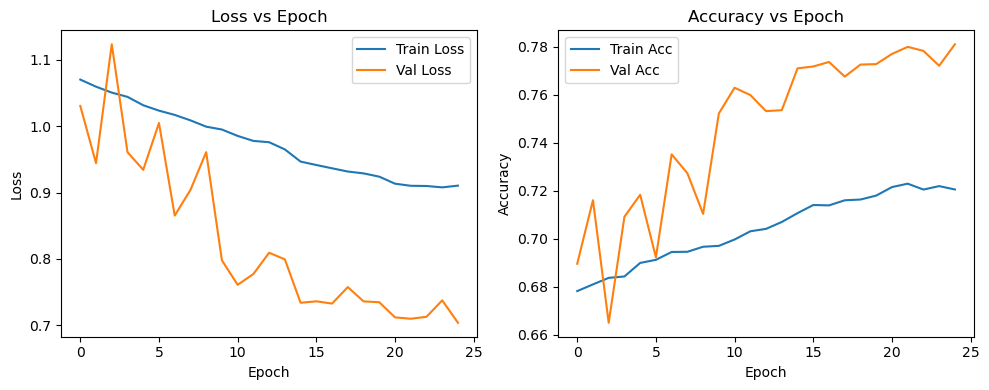

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step


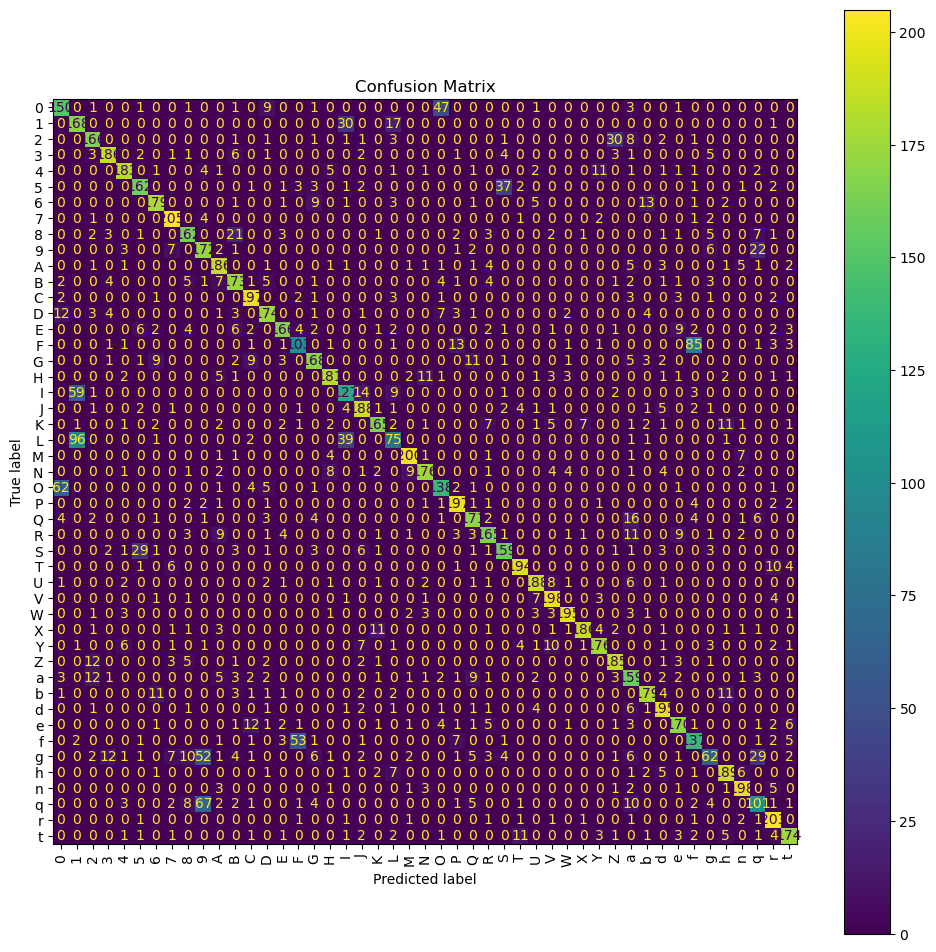

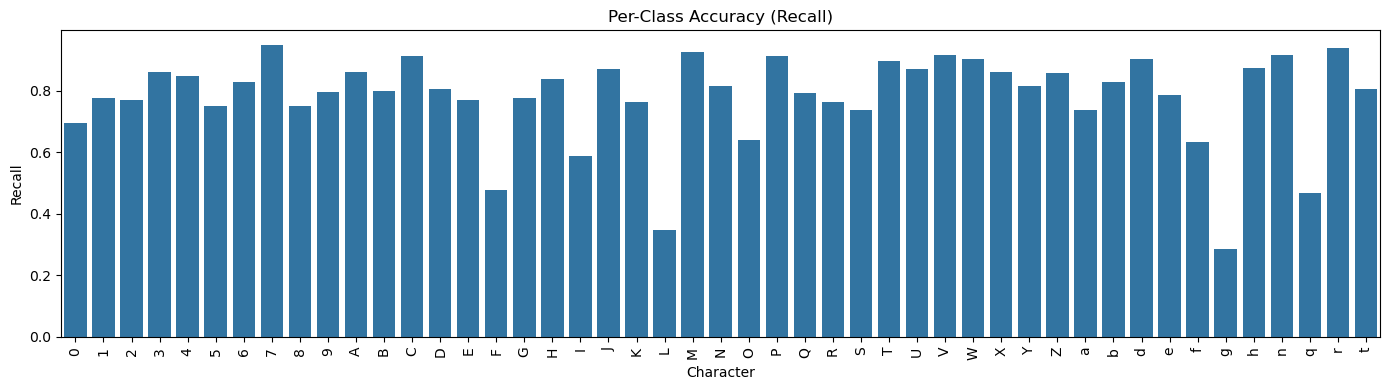

318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step


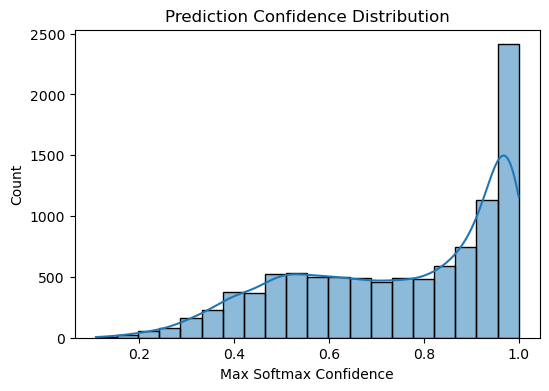

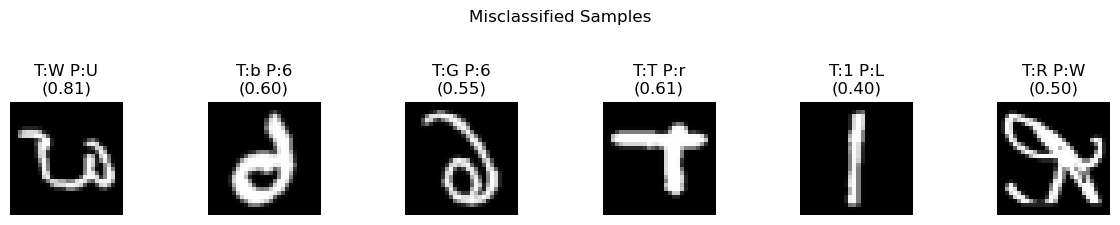

Top-3 Accuracy: 0.9473


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


plt.figure(figsize=(10, 4))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



y_pred = model.predict(x_val).argmax(axis=1)
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[mapping[i] for i in sorted(mapping)])
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()



report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
per_class_recall = {mapping[int(k)]: v['recall'] for k, v in report.items() if k.isdigit()}

plt.figure(figsize=(14, 4))
sns.barplot(x=list(per_class_recall.keys()), y=list(per_class_recall.values()))
plt.xticks(rotation=90)
plt.title("Per-Class Accuracy (Recall)")
plt.ylabel("Recall")
plt.xlabel("Character")
plt.tight_layout()
plt.show()



y_probs = model.predict(x_val)
max_confidences = y_probs.max(axis=1)

plt.figure(figsize=(6, 4))
sns.histplot(max_confidences, bins=20, kde=True)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Max Softmax Confidence")
plt.ylabel("Count")
plt.show()



wrong_idxs = np.where(y_pred != y_val)[0]
n = 6
sampled = np.random.choice(wrong_idxs, n)

plt.figure(figsize=(12, 2))
for i, idx in enumerate(sampled):
    img = x_val[idx].squeeze()
    true_lbl = mapping[y_val[idx]]
    pred_lbl = mapping[y_pred[idx]]
    conf = y_probs[idx][y_pred[idx]]

    plt.subplot(1, n, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T:{true_lbl} P:{pred_lbl}\n({conf:.2f})")
    plt.axis('off')
plt.suptitle("Misclassified Samples", y=1.1)
plt.tight_layout()
plt.show()



top_k = 3
top_k_correct = np.any(np.argsort(y_probs, axis=1)[:, -top_k:] == y_val[:, None], axis=1)
top_k_acc = np.mean(top_k_correct)
print(f"Top-{top_k} Accuracy: {top_k_acc:.4f}")


In [ ]:

data = np.load('data/emnist_balanced.npz')
x_raw = data['x']           
y = data['y']


x = np.transpose(x_raw, (0, 2, 1))
x = np.flip(x, axis=2)
x = x.astype('float32') / 255.0
x = x[..., np.newaxis]


from sklearn.model_selection import train_test_split

x_train, x_temp, x_raw_train, x_raw_temp, y_train, y_temp = train_test_split(
    x, x_raw, y, test_size=0.3, random_state=42, stratify=y
)

x_val, x_test, x_raw_val, x_raw_test, y_val, y_test = train_test_split(
    x_temp, x_raw_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


[1] True Index: 6 → '6'
    Input min/max: 0.00/0.00
    Predicted Index: 6 → '6' with confidence 0.94
    Top 3 predictions: [('6', np.float32(0.93941945)), ('G', np.float32(0.060193002)), ('S', np.float32(8.87743e-05))]


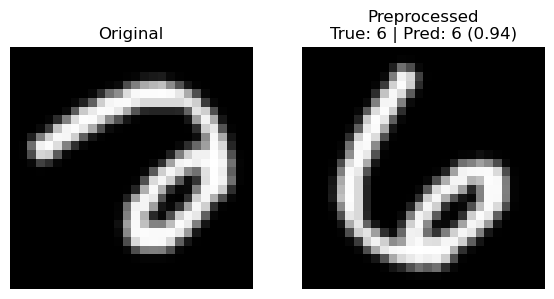

[2] True Index: 0 → '0'
    Input min/max: 0.00/0.00
    Predicted Index: 0 → '0' with confidence 0.56
    Top 3 predictions: [('0', np.float32(0.55820686)), ('O', np.float32(0.3364215)), ('D', np.float32(0.09163904))]


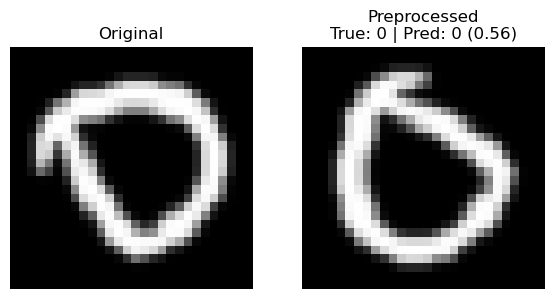

[3] True Index: 11 → 'B'
    Input min/max: 0.00/0.00
    Predicted Index: 27 → 'R' with confidence 0.47
    Top 3 predictions: [('R', np.float32(0.47430855)), ('A', np.float32(0.14360031)), ('B', np.float32(0.1195553))]


2025-05-09 18:56:38.814010: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


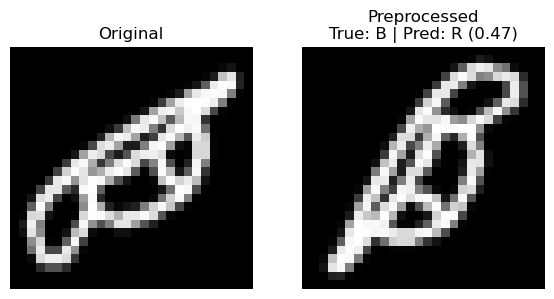

[4] True Index: 31 → 'V'
    Input min/max: 0.00/0.00
    Predicted Index: 31 → 'V' with confidence 0.93
    Top 3 predictions: [('V', np.float32(0.92887646)), ('Y', np.float32(0.056934476)), ('4', np.float32(0.005236271))]


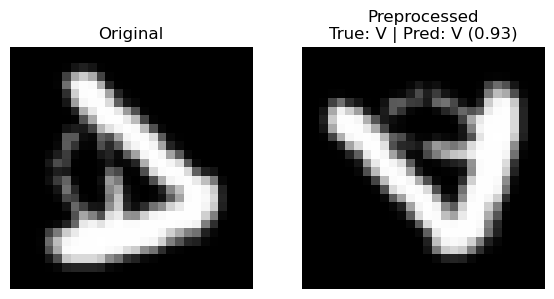

[5] True Index: 19 → 'J'
    Input min/max: 0.00/0.00
    Predicted Index: 19 → 'J' with confidence 0.96
    Top 3 predictions: [('J', np.float32(0.9608969)), ('L', np.float32(0.009461443)), ('I', np.float32(0.00790436))]


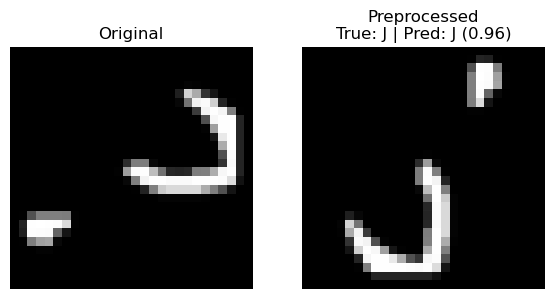

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


n = 5


idxs = np.random.choice(len(x_val), size=n, replace=False)

for i, idx in enumerate(idxs):
    
    orig_img = x_raw_val[idx]             
    proc_img = x_val[idx].squeeze()       

    
    proc_img_display = np.flip(proc_img, axis=1)

    
    true_idx = y_val[idx]
    true_lbl = mapping[true_idx]

    
    inp = proc_img.reshape(1, 28, 28, 1)
    preds = model.predict(inp, verbose=0)[0]
    pred_idx = preds.argmax()
    pred_lbl = mapping[pred_idx]
    pred_conf = preds[pred_idx]

    
    print(f"[{i+1}] True Index: {true_idx} → '{true_lbl}'")
    print(f"    Input min/max: {proc_img.min():.2f}/{proc_img.max():.2f}")
    print(f"    Predicted Index: {pred_idx} → '{pred_lbl}' with confidence {pred_conf:.2f}")
    top3_idx = preds.argsort()[-3:][::-1]
    top3 = [(mapping[i], preds[i]) for i in top3_idx]
    print("    Top 3 predictions:", top3)

    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    ax1.imshow(orig_img, cmap='gray')
    ax1.set_title("Original")
    ax1.axis('off')

    ax2.imshow(proc_img_display, cmap='gray')
    ax2.set_title(f"Preprocessed\nTrue: {true_lbl} | Pred: {pred_lbl} ({pred_conf:.2f})")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()
